In [2]:
import numpy as np
import pandas as pd


# 코골이 모델 함수

def event_indices_to_ranges(indices, hold_step=10):
    start_index = 0
    index_ranges = []
    for i in indices:
        if start_index == 0:
            start_index = i
            previous_index = i
            continue
        if i - previous_index < hold_step:
            previous_index = i
        else:
            index_ranges.append((start_index-1, previous_index)) # diff를 구할 때 index가 하나씩 밀리므로 -1해줌
            start_index = i
            previous_index = i
        if i == indices[-1]:
            index_ranges.append((start_index, i))
    return index_ranges

def analyze_snoring(sound, model, check_time=4, interval=2, sound_threshold=3):
    # sound가 checktime 이상 조용할 때를 수면에 들기 전단계로 판단
    max_queue_size = check_time / interval 
    queue = []
    sleep_ready_index = None
    for i in range(len(sound)):
        if len(queue) != max_queue_size:
            queue.append(sound[i])
        else:
            if sum(queue)/max_queue_size < sound_threshold:
                sleep_ready_index = i
                break
            else:
                queue.pop(0)
                queue.append(sound[i])
    X = []
    if sleep_ready_index == None:
        print("Warning: No sleep ready index")
        sleep_ready_index = 0
    for i in range(sleep_ready_index, len(sound)-5, 5):
        X.append(np.array(sound[i:i+5].values))
    # 모델을 이용한 코골이 판단
    predict = model.predict(X)
    # 모델 index는 5개씩 묶음이고 코콜이 유무므로 다시 1개씩으로 변환
    snoring = [0]*len(sound)
    for i, pred in enumerate(predict):
        for j in range(5):
            snoring[sleep_ready_index + i*5 + j] = pred
    # 코골이한 구간만 추출
    snoring_index = np.where(np.array(snoring) == 1)[0]
    res = event_indices_to_ranges(snoring_index, hold_step=3)
    
    # 전체 코골이 시간 추출
    total_snoring_time = 0
    for i in res:
        total_snoring_time = total_snoring_time + 2*(i[1] - i[0])
        
    # 1분 이상 코골이 구간 추출
    over_1min_snoring_ranges = list(filter(lambda x: x[1] - x[0] >= 30, res))
    # print(f"snoring: {total_snoring_time}, {over_1min_snoring_ranges}")
    return total_snoring_time, over_1min_snoring_ranges, snoring_index

In [7]:
# 코골이 모델 평가
import pickle

generalization_value = 100

snoring_model_file = '../models/snoring_model.pkl'
snoring_model = pickle.load(open(snoring_model_file, 'rb'))
feature_df = pd.read_csv('../tests/data/realtime_data_prepared.csv')
total_snoring_time, over_1min_snoring_ranges, snoring_index = analyze_snoring(feature_df['sound_value']/generalization_value, snoring_model)
print(f"total snoring time: {total_snoring_time}")
print(f"over 1min snoring ranges: {over_1min_snoring_ranges}")
print(f"snoring index: {snoring_index}")
# print("코골이 구간별 sound_value 값:")
# for start_idx, end_idx in over_1min_snoring_ranges:
#     segment_values = feature_df['sound_value'].iloc[start_idx:end_idx+1]
#     min_value = segment_values.min()
#     max_value = segment_values.max()
#     print(f"구간 {start_idx}~{end_idx}:")
#     print(f"  최소값: {min_value}")
#     print(f"  최대값: {max_value}")

# # 또는 딕셔너리 형태로 저장하고 싶다면:
# xmin_values = []
# xmax_values = []
# for start_idx, end_idx in over_1min_snoring_ranges:
#     segment_values = feature_df['sound_value'].iloc[start_idx:end_idx+1]
#     xmin_values.append(int(segment_values.min()))
#     xmax_values.append(int(segment_values.max()))

# result = {
#     'xmin': xmin_values,
#     'xmax': xmax_values
# }
# print("\n딕셔너리 형태의 결과:")
# print(result)

C:\Users\gistk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.3.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


total snoring time: 51758
over 1min snoring ranges: [(np.int64(9), np.int64(259)), (np.int64(334), np.int64(369)), (np.int64(399), np.int64(429)), (np.int64(434), np.int64(549)), (np.int64(554), np.int64(604)), (np.int64(609), np.int64(909)), (np.int64(914), np.int64(1154)), (np.int64(1159), np.int64(1199)), (np.int64(1204), np.int64(1464)), (np.int64(1469), np.int64(7009)), (np.int64(7014), np.int64(7399)), (np.int64(7404), np.int64(8229)), (np.int64(8234), np.int64(9469)), (np.int64(9474), np.int64(11494)), (np.int64(11499), np.int64(11844)), (np.int64(11849), np.int64(13544)), (np.int64(13549), np.int64(17019)), (np.int64(17024), np.int64(19829)), (np.int64(19834), np.int64(19919)), (np.int64(19924), np.int64(20644)), (np.int64(20649), np.int64(20704)), (np.int64(20709), np.int64(21249)), (np.int64(21254), np.int64(21839)), (np.int64(21844), np.int64(22439)), (np.int64(22444), np.int64(22959)), (np.int64(22964), np.int64(23719)), (np.int64(23724), np.int64(24239)), (np.int64(24244),

In [4]:
# 호흡 모델 평가
import sys, torch, pickle
sys.path.append('../models')
from lstm_model import LSTMModel

hidden_size = 50
num_layers = 1

# 스케일러 불러오기
with open('../models/breath_scaler.pkl', 'rb') as f:
    breath_scaler = pickle.load(f)

# 모델 불러오기
breath_model_file = '../models/lstm_breath_model.pth'
breath_model = LSTMModel(input_size=1, hidden_size=hidden_size, num_layers=num_layers, output_size=1)
breath_model.load_state_dict(torch.load(breath_model_file))
breath_model = breath_model.eval()

# 데이터 불러오기
feature_df = pd.read_csv('../tests/data/realtime_data_prepared.csv')
breath_nonzero_df = feature_df[feature_df['breath_rate'] != 0]
scaled_breath_rate = breath_scaler.transform(breath_nonzero_df['breath_rate'].values.reshape(-1, 1)).reshape(-1)

with torch.no_grad():
    breath_nonzero_df['breath_expect'] = breath_model(torch.tensor(scaled_breath_rate).float().view(-1, 1, 1)).view(-1).numpy()



C:\Users\gistk\AppData\Local\Temp\ipykernel_6152\2406960123.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  breath_model.load_state_dict(torch.load(breath_model_file))


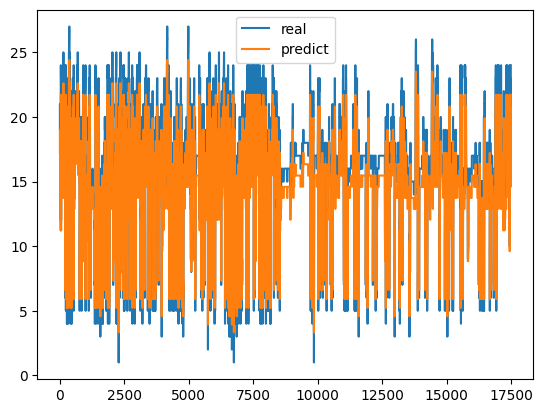

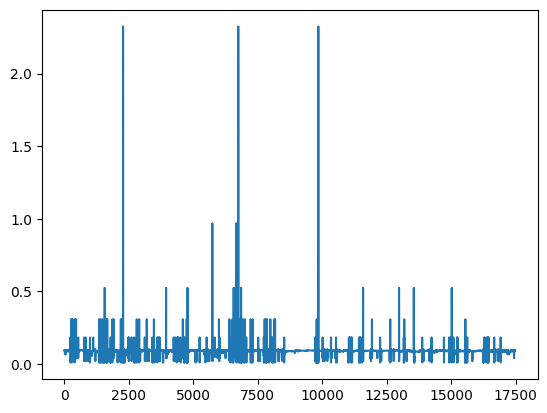

In [5]:
# 호흡 모델과 실제값 그래프로 비교
import matplotlib.pyplot as plt

predict = breath_scaler.inverse_transform(breath_nonzero_df['breath_expect'].values.reshape(-1, 1)).reshape(-1)
real = breath_nonzero_df['breath_rate'].values
plt.plot(real, label='real')
plt.plot(predict, label='predict')
plt.legend()
plt.show()

# 호흡 예측과 실제값의 오차를 그래프로 표시
plt.plot(np.abs((predict-real)/real))


In [6]:
# 심박 모델 평가

hidden_size = 50
num_layers = 1

# 스케일러 불러오기
with open('../models/heartbeat_scaler.pkl', 'rb') as f:
    heartbeat_scaler = pickle.load(f)

# 모델 불러오기
heartbeat_model_file = '../models/lstm_heartbeat_model.pth'
heartbeat_model = LSTMModel(input_size=1, hidden_size=hidden_size, num_layers=num_layers, output_size=1)
heartbeat_model.load_state_dict(torch.load(breath_model_file))
heartbeat_model = heartbeat_model.eval()

feature_df = pd.read_csv('../tests/data/realtime_data_prepared.csv')
heartbeat_nonzero_df = feature_df[feature_df['heart_rate'] != 0]
scaled_heart_rate = heartbeat_scaler.transform(heartbeat_nonzero_df['heart_rate'].values.reshape(-1, 1)).reshape(-1)

with torch.no_grad():
    heartbeat_nonzero_df['heartbeat_expect'] = heartbeat_model(torch.tensor(scaled_heart_rate).float().view(-1, 1, 1)).view(-1).numpy()



C:\Users\gistk\AppData\Local\Temp\ipykernel_6152\2924910651.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  heartbeat_model.load_state_dict(torch.load(breath_model_file

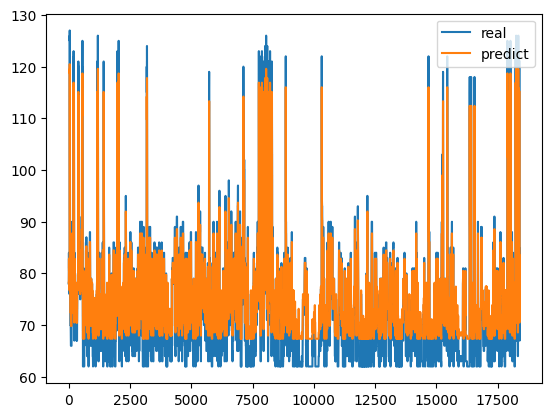

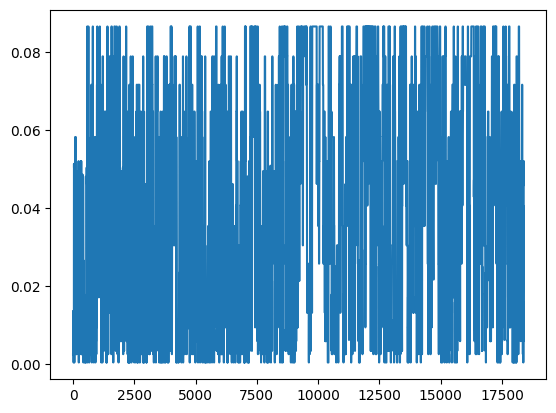

In [7]:
predict = heartbeat_scaler.inverse_transform(heartbeat_nonzero_df['heartbeat_expect'].values.reshape(-1, 1)).reshape(-1)
real = heartbeat_nonzero_df['heart_rate'].values
plt.plot(real, label='real')
plt.plot(predict, label='predict')
plt.legend()
plt.show()

# 심박 예측과 실제값의 오차를 그래프로 표시
plt.plot(np.abs((predict-real)/real))

count    26090.000000
mean         2.583902
std          7.406589
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        100.000000
Name: move_value, dtype: float64


<Axes: >

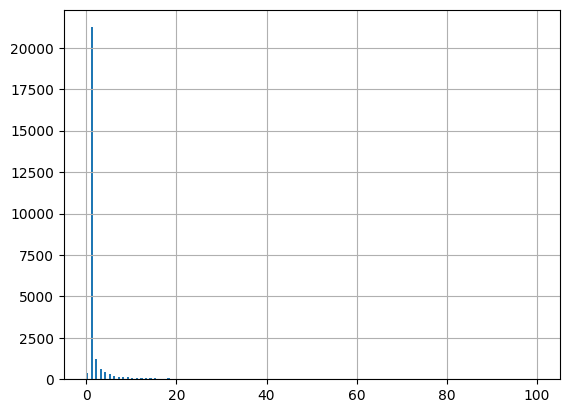

In [8]:
# 움직임 값 확인

feature_df = pd.read_csv('../tests/data/realtime_data_prepared.csv')
movement = feature_df['move_value']

# 움직임 값 기초 통계량 확인
print(movement.describe())
feature_df['move_value'].hist(bins=200)

C:\Users\gistk\AppData\Local\Temp\ipykernel_6152\3390145538.py:30: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  feature_df['breath_stable'].iloc[nonzero_breath.index] = breath_stable_predict
C:\Users\gistk\AppData\Local\Temp\ipykernel_6152\

[1. 1. 1. ... 1. 1. 1.]
0인 값의 개수: 0
0인 값의 인덱스: []
0이 존재하나요?: False
각 값의 빈도수:
값 1.0: 3183개
값 2.0: 5760개


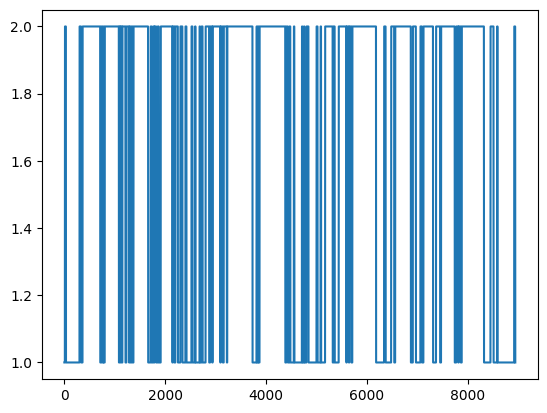

In [17]:
# 실제 센서 값 가져와서 분석하기 

# 수면 판정 파라미터
window_size = 20
sliding_window = 10
large_move_threshold = 10
breath_stable_threshold = 0.2
breath_stable_count_thres = 6
heartbeat_stable_threshold = 0.2
heartbeat_stable_count_thres = 12
default_sleep_state = 1 # 수면 상태: 0 깨어있음, 1 얕은 수면, 2 깊은 수면

def lstm_predict(data_nonzero, threshold, scale_model, lstm_model):
    scaled_data = scale_model.transform(data_nonzero.values.reshape(-1, 1)).reshape(-1)
    with torch.no_grad():
        predict = lstm_model(torch.tensor(scaled_data).float().view(-1, 1, 1))
    expected = scale_model.inverse_transform(predict.view(-1).numpy().reshape(-1, 1)).reshape(-1)
    result = np.abs((expected - data_nonzero.values)/data_nonzero.values) <= threshold
    return result

# 수면 판정
flag_move_large = []
breath_idx = []
heartbeat_idx = []
feature_df = pd.read_csv('../tests/data/realtime_data_test_prepared.csv')
# 모델을 이용한 호흡판정
nonzero_breath = feature_df[feature_df['breath_rate'] != 0]
breath_stable_predict = lstm_predict(nonzero_breath['breath_rate'], breath_stable_threshold, breath_scaler, breath_model)
feature_df['breath_stable'] = np.nan
feature_df['breath_stable'].iloc[nonzero_breath.index] = breath_stable_predict
# 모델을 이용한 심박판정
nonzero_heartbeat = feature_df[feature_df['heart_rate'] != 0]
heartbeat_stable_predict = lstm_predict(nonzero_heartbeat['heart_rate'], heartbeat_stable_threshold, heartbeat_scaler, heartbeat_model)
feature_df['heartbeat_stable'] = np.nan
feature_df['heartbeat_stable'].iloc[nonzero_heartbeat.index] = heartbeat_stable_predict

sleep = np.zeros(len(feature_df))
for i in range(0, len(feature_df), sliding_window):
    # 1. 움직임이 큰 경우
    if feature_df['move_value'].iloc[i:i+window_size].mean() > large_move_threshold:
        sleep[i:i+sliding_window] = default_sleep_state
    elif feature_df['heart_rate'].iloc[i:i+window_size].where(feature_df['heart_rate'] != 0).count() == 0:
        sleep[i:i+sliding_window] = sleep[i-1] if i != 0 else default_sleep_state
    # 2. 심박이 안정한 경우
    elif feature_df['heartbeat_stable'].iloc[i:i+window_size].where(feature_df['heartbeat_stable'] == True).count() > heartbeat_stable_count_thres:
        sleep[i:i+sliding_window] = 2
    # 3. 호흡이 안정한 경우
    elif feature_df['breath_stable'].iloc[i:i+window_size].where(feature_df['breath_stable'] == True).count() > breath_stable_count_thres:
        sleep[i:i+sliding_window] = 1
    else:
        sleep[i:i+sliding_window] = default_sleep_state

print(sleep)





# print(sleep)
# 각 측정 포인트 별 수면 판정 결과 그래프로 표시
plt.plot(sleep)
plt.show()

         day        hour         min  sleep_mode
count  283.0  283.000000  283.000000  283.000000
mean     9.0    7.667845   28.929329    1.667845
std      0.0    1.410167   17.659163    0.471821
min      9.0    5.000000    0.000000    1.000000
25%      9.0    6.000000   14.000000    1.000000
50%      9.0    8.000000   28.000000    2.000000
75%      9.0    9.000000   45.000000    2.000000
max      9.0   10.000000   59.000000    2.000000


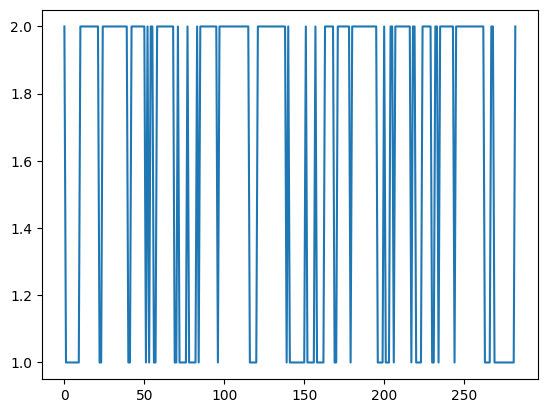

In [9]:
# 정답지와 비교를 위해 분단위로 변환
predict_df = pd.DataFrame()
predict_df['day'] = feature_df['day']
predict_df['hour'] = feature_df['hour']
predict_df['min'] = feature_df['min']
predict_df['sleep_mode'] = sleep
# 수면 판정 결과를 분단위로 묶어 최빈값으로 변환, 이 때 최빈값이 2개 이상인 경우 직전 값으로 변환
predict_df = predict_df.groupby(['day', 'hour', 'min'])['sleep_mode'].agg(pd.Series.mode).reset_index()
def is_np_array(value):
    if type(value) == np.ndarray:
        return True
    else:
        return False
for index, row in predict_df.iterrows():
    if is_np_array(row['sleep_mode']):
        predict_df.loc[index, 'sleep_mode'] = predict_df.loc[index-1, 'sleep_mode']
    assert not is_np_array(predict_df.loc[index, 'sleep_mode']), f"np array: {predict_df.loc[index, 'sleep_mode']}"
    
predict_df['sleep_mode'] = predict_df['sleep_mode'].values.astype(int)

print(predict_df.describe())
plt.plot(predict_df['sleep_mode'])
plt.show()


       sleep_mode
count  283.000000
mean     1.724382
std      0.447617
min      1.000000
25%      1.000000
50%      2.000000
75%      2.000000
max      2.000000


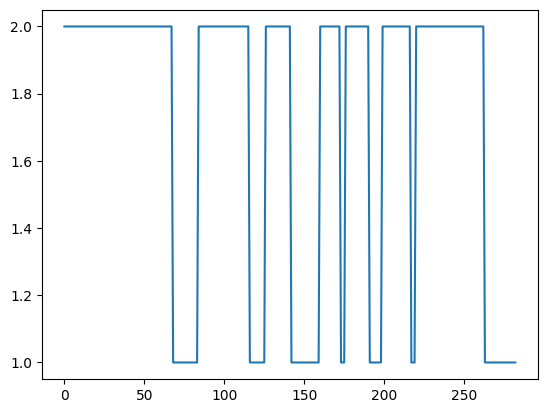

In [11]:
# 정답지 불러오기
truth_df = pd.read_csv('../tests/data/watch_data_test_prepared.csv')
print(truth_df.describe())
plt.plot(truth_df['sleep_mode'])
plt.show()

In [13]:
# 정확도 계산
def caculate_accuracy(predict_df, truth_df):
    class_1_count = 0; class_1_correct = 0; class_1_false = 0
    class_2_count = 0; class_2_correct = 0; class_2_false = 0
    for index, row in truth_df.iterrows():
        if row['sleep_mode'] == 1:
            class_1_count += 1
            if row['sleep_mode'] == predict_df.iloc[index]['sleep_mode']:
                class_1_correct += 1
            else:
                class_1_false += 1
        elif row['sleep_mode'] == 2:
            class_2_count += 1
            if row['sleep_mode'] == predict_df.iloc[index]['sleep_mode']:
                class_2_correct += 1
            else:
                class_2_false += 1
    return class_1_count, class_1_correct, class_1_false, class_2_count, class_2_correct, class_2_false

class_1_count, class_1_correct, class_1_false, class_2_count, class_2_correct, class_2_false = caculate_accuracy(predict_df, truth_df)
print("Class 1 (Light sleep)")
print(f"Count: {class_1_count}, Correct: {class_1_correct}, False: {class_1_false}")
print(f"Accuracy(IoU): {class_1_correct/class_1_count}")
print()
print("Class 2 (Deep sleep)")
print(f"Count: {class_2_count}, Correct: {class_2_correct}, False: {class_2_false}")
print(f"Accuracy(IoU): {class_2_correct/class_2_count}")

Class 1 (Light sleep)
Count: 78, Correct: 54, False: 24
Accuracy(IoU): 0.6923076923076923

Class 2 (Deep sleep)
Count: 205, Correct: 165, False: 40
Accuracy(IoU): 0.8048780487804879


In [321]:
# predict 결과값 csv로 저장
predict_df['testtime'] = '2024-10-' + predict_df['day'].map('{:02d}'.format) + ' ' + predict_df['hour'].map('{:02d}'.format) + ':' + predict_df['min'].map('{:02d}'.format)
predict_df[['testtime', 'sleep_mode']].to_csv('../tests/result/predict_sleep_mode.csv', index=False)